# Mount the Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Essential functions


In [0]:
def convert_labels(labels):
    tmp_labels = np.zeros(labels.shape).astype(int)
    original_labels = [0,1,10,11,13,15,16,18,20,30,31,32,
                       40,44,48,49,50,51,52,60,70,71,72,
                       80,81,88,252,253,254,255,256,257,258,259]
    for i  in range(len(original_labels)):
        tmp_labels[np.where(labels == original_labels[i])] = int(i)
    return tmp_labels

def convert_labels_original(conv_labels):
    tmp_labels = np.zeros(conv_labels.shape).astype(int)
    original_labels = [0,1,10,11,13,15,16,18,20,30,31,32,
                       40,44,48,49,50,51,52,60,70,71,72,
                       80,81,88,252,253,254,255,256,257,258,259]
    for i  in range(len(original_labels)):
        tmp_labels[np.where(conv_labels == i)] = original_labels[i]
    return tmp_labels

# Visualize the Raw Rimage

88720.0


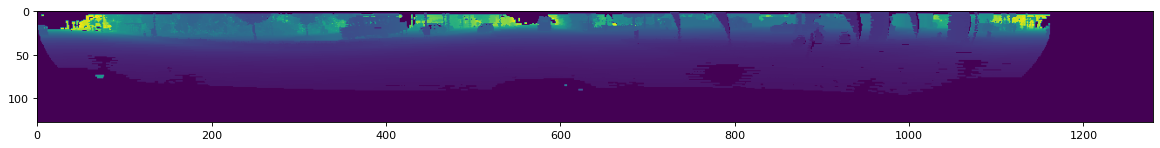

In [3]:
import numpy as np
from numpy import linalg as LA
seq = '04'
file_path = '/content/drive/My Drive/Colab Notebooks/PointCloudSegmentation/_data/sequences/' + seq + '/range_images/000000.bin'
# load the file"
f = open(file_path, "rb")
# data = f.read()
data = np.fromfile(f, dtype=np.int16)

rimage_height = 128
rimage_width = 1280
# data = data[2:]
idx_x = data[np.arange(0,len(data),5)]
idx_y = data[np.arange(1,len(data),5)]
x = data[np.arange(2,len(data),5)] / 100
y = data[np.arange(3,len(data),5)] / 100
z = data[np.arange(4,len(data),5)] / 100
f.close()

pt = np.vstack((x,y,z)).T
r = LA.norm(pt, axis=1)

rimage = np.zeros((rimage_height, rimage_width))
rimage[idx_y, idx_x] = r

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(rimage)

print(len(data)/5)

## Visualize range image with labels

rimage height: 98
rimage width: 1163


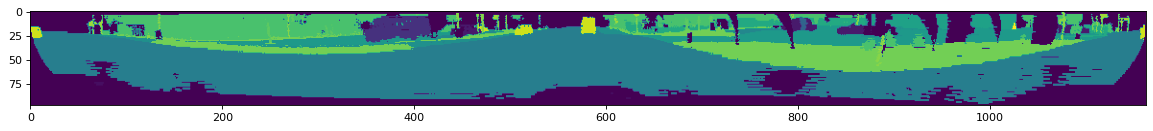

In [4]:
import numpy as np
from numpy import linalg as LA
file_path = '/content/drive/My Drive/Colab Notebooks/PointCloudSegmentation/_data/sequences/' + seq + '/labels_range_images/000000.label'
# load the file"
f = open(file_path, "rb")
# data = f.read()


labels = np.fromfile(f, dtype=np.int16)
rimage_height = labels[0]
rimage_width = labels[1]
labels = labels[2:]
conv_labels = convert_labels(labels)
limage = np.zeros((rimage_height, rimage_width))
limage[idx_y, idx_x] = conv_labels
f.close()

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(limage)

print('rimage height: ' + str(rimage_height))
print('rimage width: ' + str(rimage_width))

# Plot the Estimate Based on Neural Network

## Import NN models

In [4]:
from keras import datasets, layers, models
from keras.models import Sequential
from tensorflow.python.keras.utils.data_utils import Sequence
from keras import applications
from keras.layers.pooling import MaxPooling2D, AveragePooling2D

from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

def RIU_net(image_shape):
    # Build U-Net model
    # inputs = Input((256, 1280, 1))
    inputs = Input(image_shape)
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(34, (1, 1), activation='softmax') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    optimizer = optimizers.adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
    model.summary()
    return model

Using TensorFlow backend.


## Load pre-trained model and evaluate

In [6]:
from keras.utils import np_utils
from IPython.core.debugger import set_trace
import numpy as np
from numpy import linalg as LA

# Create a new model instance
# seq = ['00','01','02','03','04','05','06','07','08','09','10']
seq = ['08','09','10']
b_save = True
rimage_max_height = 128
rimage_max_width = 1280
model = RIU_net((rimage_max_width,rimage_max_height,1))
model_name = 'RIU_net'

# # Restore the weights
model.load_weights('/content/drive/My Drive/Colab Notebooks/PointCloudSegmentation/models/good/RIU_net_100_010405060709_acc96_v4.h5')
data_path = '/content/drive/My Drive/Colab Notebooks/PointCloudSegmentation/_data/sequences/'

files = []
for i in range(len(seq)):
    f = open(data_path + seq[i] + '/list.txt', "r")
    data = f.readlines()
    f.close()
    for j in range(len(data)):
        files.append(seq[i] + ',' + data[j].rstrip())

heights = []
widths = []
predicted_labels = []
gt_labels = []
ximages = []
yimages = []
zimages = []
for i in range(len(files)):
    if (i % 100 == 0):
        print(str(i))
    else:
        print(str(i) + ' ', end = '')
    # Image 
    range_normalizer = 120
    file_path = data_path + files[i].split(',')[0] + '/range_images/' + files[i].split(',')[1] + '.bin'
    f = open(file_path, "rb")
    data = np.fromfile(f, dtype=np.int16)
    idx_x = data[np.arange(0,len(data),5)]
    idx_y = data[np.arange(1,len(data),5)]
    x = data[np.arange(2,len(data),5)] / 100
    y = data[np.arange(3,len(data),5)] / 100
    z = data[np.arange(4,len(data),5)] / 100
    f.close()
    pt = np.vstack((x,y,z)).T
    r = LA.norm(pt, axis=1) # range
    rimage = np.zeros((rimage_max_width, rimage_max_height))
    rimage[idx_x,idx_y] = r/range_normalizer
    ximage = np.zeros((rimage_max_width, rimage_max_height))
    ximage[idx_x,idx_y] = x
    # ximages.append(ximage)
    yimage = np.zeros((rimage_max_width, rimage_max_height))
    yimage[idx_x,idx_y] = y
    # yimages.append(yimage)
    zimage = np.zeros((rimage_max_width, rimage_max_height))
    zimage[idx_x,idx_y] = z
    # zimages.append(zimage)

    rimage = np.expand_dims(rimage.reshape((rimage_max_width,rimage_max_height,1)), axis=0)

    # Ground Truth Labels
    label_path = data_path + files[i].split(',')[0] + '/labels_range_images/' + files[i].split(',')[1] + '.label'
    f = open(label_path, "rb")
    labels = np.fromfile(f, dtype=np.int16)
    rimage_height = labels[0]
    # heights.append(rimage_height)
    rimage_width = labels[1]
    # widths.append(rimage_width)
    limage = np.zeros((rimage_width, rimage_height))
    limage[idx_x,idx_y] = labels[2:]
    # gt_labels.append(limage.ravel())

    # Predicted Labels
    out = model.predict(rimage)
    out = out.reshape((rimage_max_width, rimage_max_height, 34))
    max_idx = np.argmax(out, axis=2)
    # predicted_labels.append(max_idx)

    # Write predictions to drive
    if (b_save == True):
        # Generate Velodyne .bin files
        x = ximage[0:rimage_width,0:rimage_height].ravel()
        y = yimage[0:rimage_width,0:rimage_height].ravel()
        z = zimage[0:rimage_width,0:rimage_height].ravel()
        r = np.ones(x.shape)
        xyzr = np.dstack((x,y,z,r)).ravel()
        xyzr = np.array(xyzr,'float32')
        xyzr_file = open(data_path + files[i].split(',')[0] + '/predicted/velodyne/' + files[i].split(',')[1] + '.bin', 'wb')
        xyzr.tofile(xyzr_file)
        xyzr_file.close()

        # Generate Predictions .label files
        predictions = max_idx[0:rimage_width,0:rimage_height].ravel()
        predictions = np.array(predictions, 'uint32')
        predictions_file = open(data_path + files[i].split(',')[0]  + '/predicted/predictions/' + files[i].split(',')[1] + '.label', 'wb')
        predictions.tofile(predictions_file)
        predictions_file.close()

        # Generate Lables .label files (ground truth)
        gt = limage.ravel()
        gt = convert_labels(gt)
        gt = np.array(gt, 'uint32')
        gt_file = open(data_path + files[i].split(',')[0]  + '/predicted/labels/' + files[i].split(',')[1] + '.label', 'wb')
        gt.tofile(gt_file)
        gt_file.close()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1280, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1280, 128, 1) 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 1280, 128, 64 640         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 1280, 128, 64 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

## Plot

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_num = 0
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(predicted_labels[img_num][0:widths[img_num],0:heights[img_num]].T)

## Save binary files for point cloud and labels


In [0]:
for i in range(len(predicted_labels)):
    # Generate Velodyne .bin files
    x = ximages[i][0:widths[i],0:heights[i]].ravel()
    y = yimages[i][0:widths[i],0:heights[i]].ravel()
    z = zimages[i][0:widths[i],0:heights[i]].ravel()
    r = np.ones(x.shape)
    xyzr = np.dstack((x,y,z,r)).ravel()
    xyzr = np.array(xyzr,'float32')
    xyzr_file = open(data_path + seq[0] + '/predicted/velodyne/' + str(i).zfill(6) + '.bin', 'wb')
    xyzr.tofile(xyzr_file)
    xyzr_file.close()

    # Generate Predictions .label files
    predictions = predicted_labels[i][0:widths[i],0:heights[i]].ravel()
    predictions = np.array(predictions, 'uint32')
    predictions_file = open(data_path + seq[0] + '/predicted/predictions/' + str(i).zfill(6) + '.label', 'wb')
    predictions.tofile(predictions_file)
    predictions_file.close()

    # Generate Lables .label files (ground truth)
    gt = gt_labels[i]
    gt = np.array(gt, 'uint32')
    gt_file = open(data_path + seq[0] + '/predicted/labels/' + str(i).zfill(6) + '.label', 'wb')
    gt.tofile(gt_file)
    gt_file.close()